In [1]:
import cudf
import cuml
from datetime import datetime
import requests
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
import cupy as cp
from cuml.tsa.arima import ARIMA
import pandas as pd
from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from cuml import ExponentialSmoothing
import os

import warnings
import itertools
plt.style.use('fivethirtyeight')

In [3]:
load = cudf.read_csv('OASIS_Real_Time_Dispatch_Actual_Load.csv')

# # Convert to datetime
load['RTD End Time Stamp'] = pd.Series(load['RTD End Time Stamp'].to_pandas()).astype('datetime64')
load['RTD Actual Load'] = pd.Series(load['RTD Actual Load'].to_pandas()).astype('float64')
# lets look at new york city for simplicity
nyc = load[load['Zone Name']== 'N.Y.C.']
# nyc = ny.set_index('RTD End Time Stamp')

nyc['DT'] = nyc['RTD End Time Stamp']

nyc['day'] = nyc['DT'].dt.day
nyc = nyc.set_index('DT')
nyc 

,RTD End Time Stamp,Zone Name,Zone PTID,RTD Actual Load,day
DT,,,,,
2021-06-01 00:05:00,2021-06-01 00:05:00,N.Y.C.,61761,4194.2970,1
2021-06-01 00:10:00,2021-06-01 00:10:00,N.Y.C.,61761,4175.2285,1
2021-06-01 00:15:00,2021-06-01 00:15:00,N.Y.C.,61761,4173.5070,1
2021-06-01 00:20:00,2021-06-01 00:20:00,N.Y.C.,61761,4140.1562,1
2021-06-01 00:25:00,2021-06-01 00:25:00,N.Y.C.,61761,4102.7010,1
...,...,...,...,...,...
2021-06-30 23:40:00,2021-06-30 23:40:00,N.Y.C.,61761,7693.3410,30
2021-06-30 23:45:00,2021-06-30 23:45:00,N.Y.C.,61761,7679.4210,30
2021-06-30 23:50:00,2021-06-30 23:50:00,N.Y.C.,61761,7685.7920,30


In [4]:
nyc.groupby('day').count()['Zone Name'].mean()

293.76666666666665

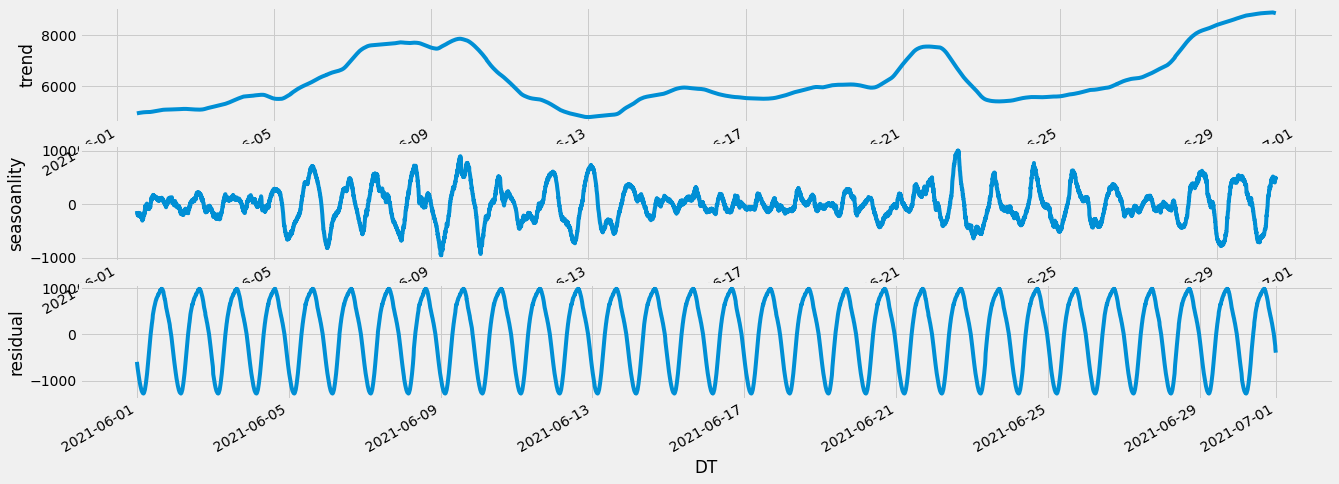

<Figure size 432x288 with 0 Axes>

In [5]:
# lets do a seasonal decomposition to look at the trend, seasonality, and residuals
res=sm.tsa.seasonal_decompose(nyc['RTD Actual Load'].to_pandas(),model='add',period=294);
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()
plt.tight_layout()
# it looks like this data is trending upwards

In [5]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
%%time
# Finding the order and seasonal order
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX( nyc['RTD Actual Load'].to_pandas(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:179603.384524175
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:172845.75412355864
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:121559.50176403642
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:114030.3064503675
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:121575.05745555366
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:114201.22972459765
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:108260.62158721131
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:107604.87125588249
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:172999.69778454895
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:171130.61793278667
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:110903.45125000288
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:106479.9926812386
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:110932.0144155905
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:106618.33967150626
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:101976.67783514537
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:101928.79621174751
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:85182.4596635793
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:83803.50768191581


In [6]:
%%time
mod = sm.tsa.statespace.SARIMAX(nyc['RTD Actual Load'].to_pandas(),
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()


/opt/conda/envs/rapids/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 3.8 s, sys: 779 ms, total: 4.58 s
Wall time: 3.83 s


/opt/conda/envs/rapids/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


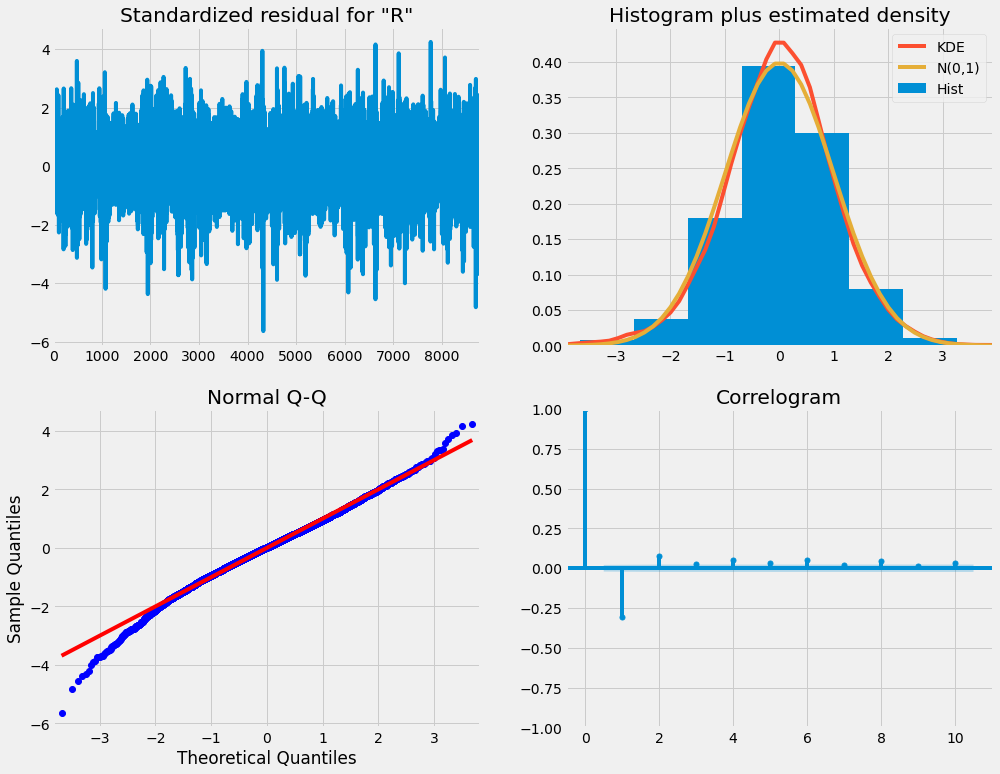

In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# so what do we see?  
# - the residuals are normally distributed. (top-right)
# -the ordered distribution of residuals (blue dots) follows the linear trend of the sample (Q-Q, bottom left)
# - the residuals over time dont seem to show any particular seasonality (top left). looks like white noise
# 


In [8]:
pred = results.get_prediction(start=pd.to_datetime('2021-06-20 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

pred_dynamic = results.get_prediction(start=pd.to_datetime('2021-06-20 00:00:00'), dynamic=True, full_results=True)


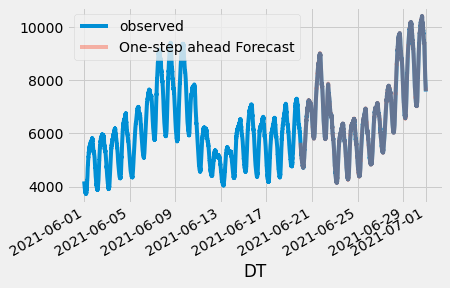

In [9]:
nyc_pan = nyc.to_pandas()

ax = nyc_pan['RTD Actual Load'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.4)




plt.legend()

plt.show()

In [11]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()



/opt/conda/envs/rapids/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [12]:
pred_uc.predicted_mean

8813    7547.138520
8814    7522.285159
8815    7492.824630
8816    7469.181458
8817    7441.144733
           ...     
9308    4892.852581
9309    4892.686665
9310    4892.522453
9311    4892.359928
9312    4892.199071
Name: predicted_mean, Length: 500, dtype: float64

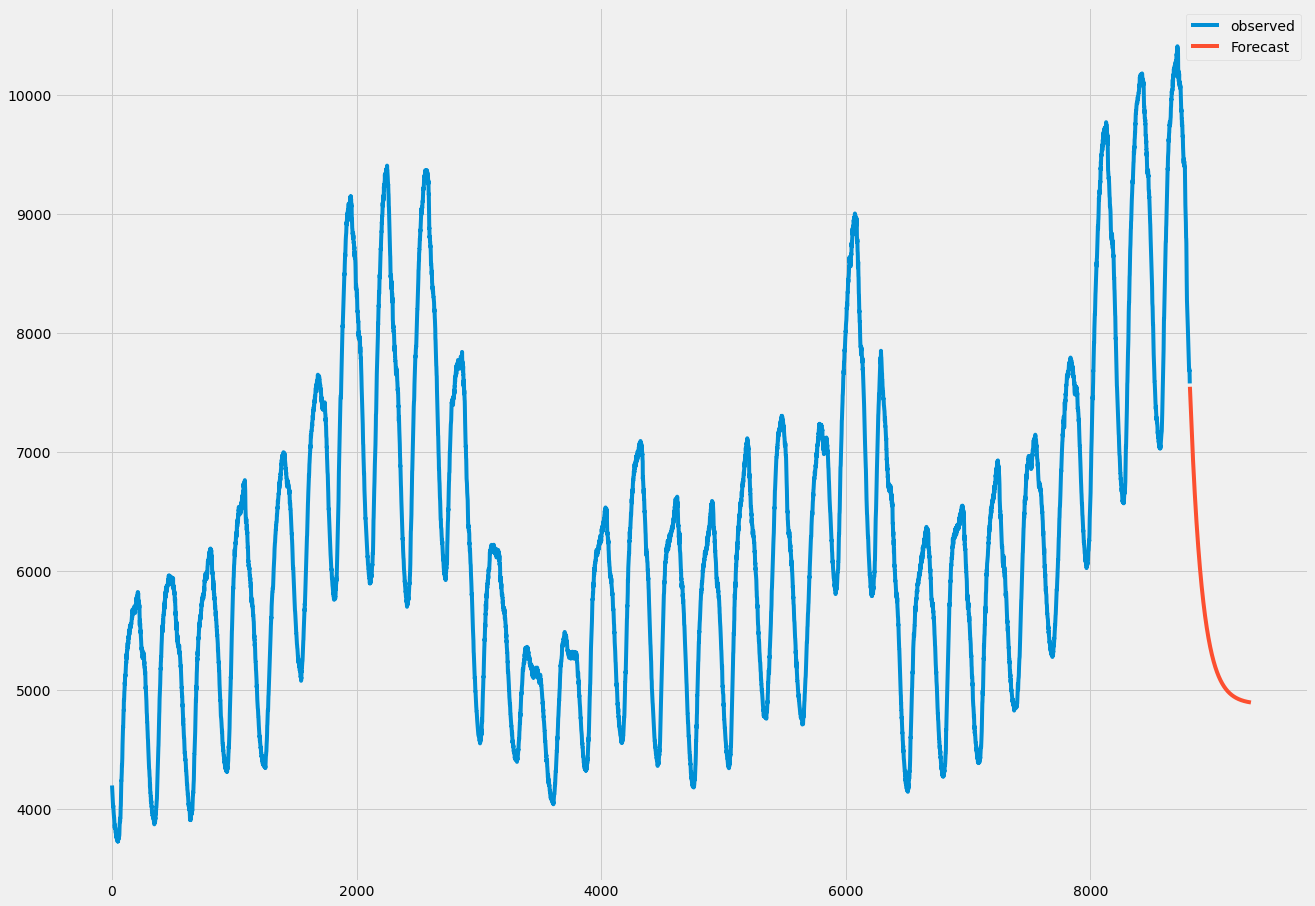

In [13]:
nyc_pan2 = nyc_pan.reset_index()
ax = nyc_pan2['RTD Actual Load'].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')


plt.legend()
plt.show()

# AutoArima

In [14]:

from cuml.tsa.auto_arima import AutoARIMA

auto_pop = AutoARIMA(nyc['RTD Actual Load'].values)

nyc['RTD Actual Load'].values.shape

(8813,)

In [15]:
%%time
auto_pop.search(s=1, d=(1,2), D=(0,1,2), p=(0,1,2), q=(0,1,2),P=(0,1), Q=(0,1))


[I] [18:12:04.432300] Deciding D...
[I] [18:12:04.432479] Deciding d...
[I] [18:12:04.434711] Deciding p, q, P, Q, k...
[W] [18:12:05.984987] fit: Some batch members had optimizer problems
[I] [18:13:02.200322] Finalizing...
CPU times: user 40.4 s, sys: 17.4 s, total: 57.8 s
Wall time: 57.8 s


In [16]:
%%time
auto_pop.fit()

CPU times: user 9.41 s, sys: 4.08 s, total: 13.5 s
Wall time: 13.5 s


In [268]:
%%time

# Predict in-sample and forecast out-of-sample
auto_pred = auto_pop.predict(6609, 8823)

# auto_pred = auto_pop.forecast(2204)


CPU times: user 14.9 ms, sys: 8.14 ms, total: 23.1 ms
Wall time: 23.1 ms


In [269]:
auto_pred = [float(item) for sublist in auto_pred for item in sublist]

auto_pred

[5996.75184413757,
 6044.153971003776,
 6054.439668088674,
 6051.095881527459,
 6034.069267777742,
 6060.31949208336,
 6075.702576022171,
 6084.1138329538035,
 6079.784379759642,
 6116.999632087187,
 6087.844743795515,
 6113.037774646849,
 6106.770315875335,
 6134.584078221544,
 6138.881630155529,
 6133.187553130463,
 6129.6243915312625,
 6139.8486020472355,
 6115.764331929951,
 6145.924755876098,
 6154.639296089981,
 6192.1458902472605,
 6193.2423674009015,
 6194.853435885534,
 6180.102534863633,
 6195.972985061677,
 6212.495931133097,
 6216.410492048917,
 6207.962790124622,
 6205.759717087026,
 6222.3288474932215,
 6218.685118953143,
 6218.015182420735,
 6240.535003301172,
 6263.7765745069155,
 6257.300539877141,
 6276.250997825022,
 6274.219068716676,
 6278.086288070795,
 6301.5074981983835,
 6308.167432431479,
 6324.636065260112,
 6252.786512391542,
 6296.950536033328,
 6329.248695181816,
 6337.834404543612,
 6325.1846958800625,
 6329.509159790377,
 6329.321920220729,
 6329.1515734

In [270]:
nyc['RTD Actual Load'][-2214:].values

array([5939.734 , 5963.213 , 5970.1875, ..., 7685.792 , 7629.401 ,
       7575.3096])

In [271]:
res = cudf.DataFrame()
res['pred'] = auto_pred
res['actual'] = nyc['RTD Actual Load'][-2214:].values
# nyc['RTD Actual Load'][-2214:].values

# As you can see, the performance is roughly similar to the cpu version
# print(cuml.metrics.regression.mean_squared_error((res['actual'].values), (res['pred'].values), squared = False))
res

,pred,actual
0,5996.751844,5939.7340
1,6044.153971,5963.2130
2,6054.439668,5970.1875
3,6051.095882,5985.1700
4,6034.069268,5962.1504
...,...,...
2209,7444.800575,7693.3410
2210,7421.302518,7679.4210
2211,7398.073027,7685.7920
2212,7375.109026,7629.4010


In [272]:
# is there a way to not convert to pandas?
x = res.index.to_pandas()
y = res['actual'].to_pandas()
y2 = res['pred'].to_pandas()


In [273]:
z =  cp.asnumpy(auto_pop.forecast(500)).flatten()
v = range(2214, 2214+500)
type(z)

z

array([7566.25646511, 7541.53935787, 7516.93739544, 7492.61485844,
       7468.57030601, 7444.80057454, 7421.30251816, 7398.07302683,
       7375.1090261 , 7352.40747673, 7329.96537426, 7307.77974863,
       7285.84766378, 7264.16621725, 7242.73253982, 7221.54379512,
       7200.59717923, 7179.88992035, 7159.41927839, 7139.18254464,
       7119.1770414 , 7099.40012162, 7079.84916854, 7060.52159539,
       7041.41484498, 7022.5263894 , 7003.85372968, 6985.39439548,
       6967.1459447 , 6949.10596323, 6931.27206457, 6913.64188956,
       6896.21310604, 6878.98340854, 6861.950518  , 6845.11218143,
       6828.46617164, 6812.01028694, 6795.74235085, 6779.66021178,
       6763.7617428 , 6748.04484131, 6732.50742879, 6717.1474505 ,
       6701.96287524, 6686.95169506, 6672.11192497, 6657.44160275,
       6642.93878859, 6628.60156494, 6614.42803616, 6600.41632832,
       6586.56458896, 6572.87098681, 6559.33371156, 6545.95097364,
       6532.72100396, 6519.64205367, 6506.71239396, 6493.93031

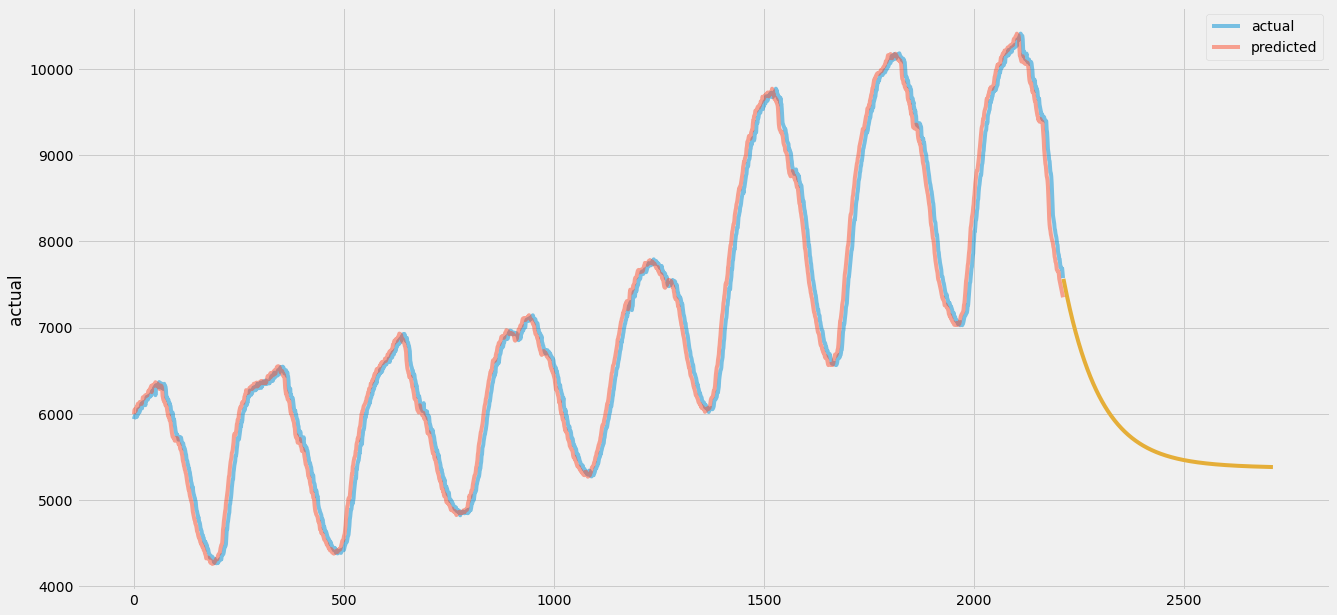

In [274]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,10))

sns.lineplot(x, y,label='actual', alpha = .5)
sns.lineplot(x,y2,label= 'predicted', alpha = .5)
sns.lineplot(v,z)
ax.legend()

# Holtwinters

In [275]:
load = cudf.read_csv('OASIS_Real_Time_Dispatch_Actual_Load.csv', parse_dates = ['RTD End Time Stamp'])

# Convert to datetime
load['RTD End Time Stamp'] = cudf.Series(load['RTD End Time Stamp'])
load['RTD Actual Load'] = cudf.Series(load['RTD Actual Load']).astype('float64')
# lets look at new york city for simplicity
ny = load[load['Zone Name']== 'CAPITL']
# ny = ny.set_index('RTD End Time Stamp')

ny.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 8813 entries, 0 to 96932
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   RTD End Time Stamp  8813 non-null   datetime64[ns]
 1   Zone Name           8813 non-null   object
 2   Zone PTID           8813 non-null   object
 3   RTD Actual Load     8813 non-null   float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 370.1+ KB


In [244]:
%%time
cu_hw = ExponentialSmoothing(ny['RTD Actual Load'], seasonal_periods=7, seasonal = 'mul')


CPU times: user 949 µs, sys: 186 µs, total: 1.14 ms
Wall time: 974 µs


In [245]:
%%time

cu_hw.fit()


CPU times: user 6.54 s, sys: 3.07 s, total: 9.62 s
Wall time: 9.59 s


ExponentialSmoothing()

In [253]:
%%time

cu_pred = cu_hw.predict(6609, 8812)


AttributeError: 

In [247]:
cu_pred

0      1600.296904
1      1595.977645
2      1588.571880
3      1583.634930
4      1578.833411
          ...     
495   -1191.116325
496   -1196.376909
497   -1201.994861
498   -1208.632270
499   -1212.929476
Length: 500, dtype: float64

In [210]:
print('Forecasted points:', cu_pred)
x = ny['RTD Actual Load']

print(cuml.metrics.regression.mean_squared_error(x, cu_pred, squared = False))


Forecasted points: 0        1606.177239
1        1602.227212
2        1609.969202
3        1603.090657
4        1607.230955
            ...     
8808   -59446.129765
8809   -59452.235938
8810   -59461.630408
8811   -59464.106316
8812   -59466.804021
Length: 8813, dtype: float64
35228.80401716533


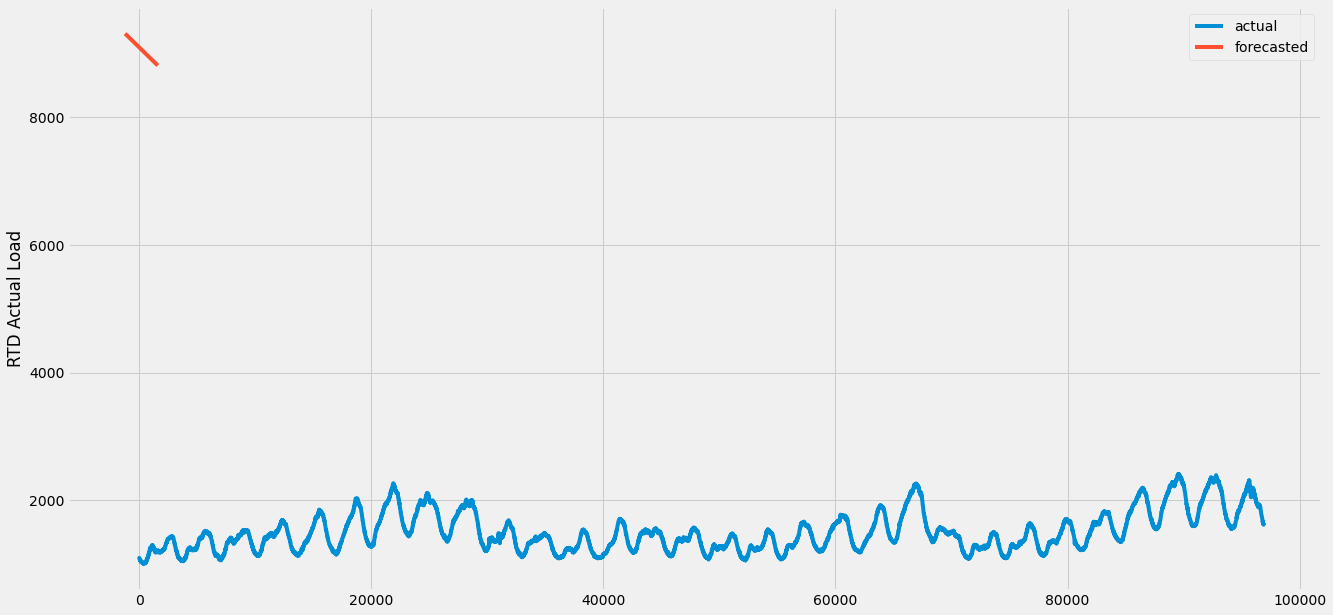

In [252]:
fig, ax = plt.subplots(figsize = (20,10))
import seaborn as sns
# is there a way to not convert to pandas?
z = ny.index.to_pandas()
y = ny['RTD Actual Load'].to_pandas()
y2 = cu_pred.to_pandas()
sns.lineplot(z,y,label='actual')
sns.lineplot(list(range(8812,,y2,label='forecasted')
ax.legend()